## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
print("Yfinance version: " , yf.__version__)

Yfinance version:  0.2.12


## Fetch cotation data

In [3]:
def fetch_stock_data(tickers, start_date, end_date, interval):
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)
    return data

In [4]:
# select tickers
tickers = ["IAU", "BRK-B"]

# date format YYYY-MM-DD
start_date = "2010-01-01"
end_date = "2024-02-01"

# time interval to take the cotations, in this case monthly
interval= "1mo"

stock_data = fetch_stock_data(tickers, start_date, end_date, interval)

display(stock_data)

[*********************100%***********************]  2 of 2 completed


Adj Close                  Close                   High  \
                 BRK-B        IAU       BRK-B        IAU       BRK-B   
Date                                                                   
2010-01-01   76.430000  21.204000   76.430000  21.204000   77.790001   
2010-02-01   80.129997  21.892000   80.129997  21.892000   80.180000   
2010-03-01   81.269997  21.806000   81.269997  21.806000   83.570000   
2010-04-01   77.000000  23.084000   77.000000  23.084000   81.949997   
2010-05-01   70.550003  23.778000   70.550003  23.778000   78.800003   
...                ...        ...         ...        ...         ...   
2023-09-01  350.299988  34.990002  350.299988  34.990002  373.339996   
2023-10-01  341.329987  37.590000  341.329987  37.590000  350.000000   
2023-11-01  360.000000  38.540001  360.000000  38.540001  363.190002   
2023-12-01  356.660004  39.029999  356.660004  39.029999  364.049988   
2024-01-01  383.739990  38.490002  383.739990  38.490002  387.920013   

                              Low                   Open             \
                  IAU       BRK-B        IAU       BRK-B        IAU   
Date                                                                  
2010-01-01  22.726000   64.720001  21.054001   66.000000  21.978001   
2010-02-01  22.077999   71.610001  20.466000   77.790001  21.322001   
2010-03-01  22.448000   79.139999  21.264000   79.989998  21.914000   
2010-04-01  23.156000   75.519997  22.002001   81.599998  22.002001   
2010-05-01  24.459999   68.480003  22.680000   77.699997  23.202000   
...               ...         ...        ...         ...        ...   
2023-09-01  36.959999  348.549988  34.959999  362.000000  36.900002   
2023-10-01  38.040001  330.579987  34.349998  349.640015  34.750000   
2023-11-01  38.799999  340.579987  36.570000  341.209991  37.549999   
2023-12-01  39.450001  350.850006  37.400002  359.940002  38.549999   
2024-01-01  39.180000  355.940002  37.880001  356.320007  39.090000   

               Volume             
                BRK-B        IAU  
Date                              
2010-01-01  121830600   25255000  
2010-02-01  565057700   29055000  
2010-03-01  154218600   14429000  
2010-04-01   92127400   24512000  
2010-05-01  122890600   43516000  
...               ...        ...  
2023-09-01   70871000  114556700  
2023-10-01   64919600  157116700  
2023-11-01   66584300  105535400  
2023-12-01   70672800  113939200  
2024-01-01   73388600  113687300  

[169 rows x 12 columns]

In [5]:
# select only the closing price
df_close = stock_data.Close.copy()
df_close.info()
df_close

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 2010-01-01 to 2024-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BRK-B   169 non-null    float64
 1   IAU     169 non-null    float64
dtypes: float64(2)
memory usage: 4.0 KB


,BRK-B,IAU
Date,,
2010-01-01,76.430000,21.204000
2010-02-01,80.129997,21.892000
2010-03-01,81.269997,21.806000
2010-04-01,77.000000,23.084000
2010-05-01,70.550003,23.778000
...,...,...
2023-09-01,350.299988,34.990002
2023-10-01,341.329987,37.590000
2023-11-01,360.000000,38.540001


## Calculate returns

### Month-over-month (MoM)

In [15]:
# find the monthly return and drop the rows with null values.
# returns_mom = df_close.copy().pct_change().dropna()

# display(returns_mom.describe())
# returns_mom.head(3)

### Year-over-year (YoY)

In [14]:
returns_yoy = df_close.copy().pct_change(periods=12).dropna()

display(returns_yoy.describe())
returns_yoy.head(3)

,BRK-B,IAU
count,157.000000,157.000000
mean,0.128374,0.043410
std,0.148189,0.144922
min,-0.162593,-0.282555
25%,0.010719,-0.056271
50%,0.125099,0.018245
75%,0.231831,0.132163
max,0.559651,0.458265


,BRK-B,IAU
Date,,
2011-01-01,0.069606,0.227127
2011-02-01,0.089230,0.259821
2011-03-01,0.029039,0.285885


### Plot

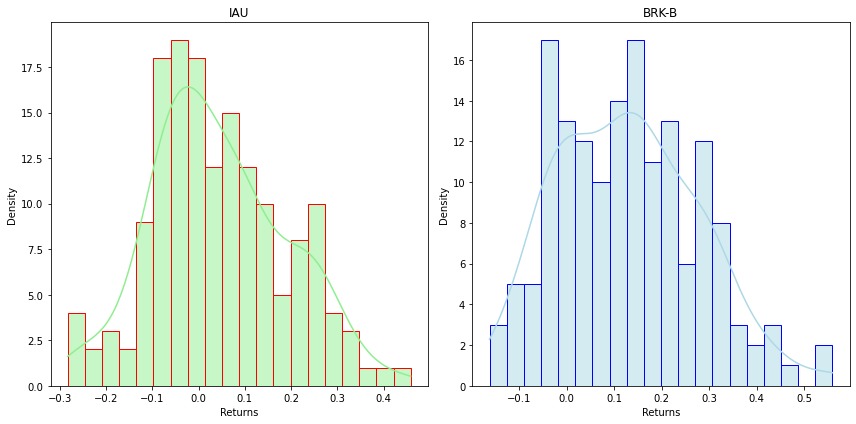

In [16]:
display()

# Create two separate plots using histplot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # First subplot
sns.histplot(data=returns_yoy, x=tickers[0], bins=20, kde=True, color='lightgreen', edgecolor='red')
plt.title(tickers[0])
plt.xlabel('Returns')
plt.ylabel('Density')

plt.subplot(1, 2, 2)  # Second subplot
sns.histplot(data=returns_yoy, x=tickers[1], bins=20, kde=True, color='lightblue', edgecolor='blue')
plt.title(tickers[1])
plt.xlabel('Returns')
plt.ylabel('Density')

plt.tight_layout()
plt.show()